# Period fit <= .25

In [4]:
import os
import itertools as it
import warnings
import time
import pickle

import numpy as np

import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns

import joblib

import pathlib

from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import DataConversionWarning

from sklearn import metrics

import tqdm

from libs.container import Container
from libs.nearest import nearest
from libs.experiment import WithAnotherExperiment, roc, metrics
from libs.precstar import  prec_star

import build

warnings.simplefilter("ignore", category=DataConversionWarning)

In [2]:
PATH = pathlib.Path(os.path.abspath(os.path.dirname("")))

DATA_PATH = PATH / "_data"

COLUMNS_NO_FEATURES = ['id', 'tile', 'cnt', 'ra_k', 'dec_k', 'vs_type', 'vs_catalog', 'cls'] 

tiles = ["b234", "b360", "b278", "b261"]

In [6]:
%%time
DATA_UNSC_NAMES = {
    "s20k.pkl.bz2": 'Large',
    "s5k.pkl.bz2": 'Mid',
    "s2_5k.pkl.bz2": 'Small',
    "sO2O.pkl.bz2": 'One-to-One',
    "s10p.pkl.bz2": 'Huge',
    "full.pkl.bz2": "Full"
}

unscaled_datas = {}
train_datas = {}
scalers = {}
for path in DATA_PATH.glob("*.pkl.bz2"):
    if path.name.endswith("_scaled.pkl.bz2"):
        continue
    print(f"Reading {path}...")
          
    sample = pd.read_pickle(path)
    sample = sample[(sample.cls == 0) | (sample.Period_fit <= .25)]
    
    X_columns = [c for c in sample.columns if c not in COLUMNS_NO_FEATURES]
    y_column = "cls"

    sample[X_columns] =  sample[X_columns].astype(np.float32)
    
    scaler, scaled = build.scale(sample)
    
    data_name = DATA_UNSC_NAMES[path.name]
    unscaled_datas[data_name] = sample[sample.tile.isin(tiles)]
    
    train_datas[data_name] = Container({k: v for k, v in scaled.groupby("tile") if k in tiles})
    scalers[data_name] = scaler

    del sample

Reading /home/jbcabral/how_far_can_we_go/_data/full.pkl.bz2...
Scaling
Reading /home/jbcabral/how_far_can_we_go/_data/s5k.pkl.bz2...
Scaling
Reading /home/jbcabral/how_far_can_we_go/_data/s2_5k.pkl.bz2...
Scaling
Reading /home/jbcabral/how_far_can_we_go/_data/sO2O.pkl.bz2...
Scaling
Reading /home/jbcabral/how_far_can_we_go/_data/s10p.pkl.bz2...
Scaling
Reading /home/jbcabral/how_far_can_we_go/_data/s20k.pkl.bz2...
Scaling
CPU times: user 2min 12s, sys: 10.8 s, total: 2min 22s
Wall time: 1min 51s


## Run the classifiers with the selected parameters

In [7]:
RF_PARAMS = joblib.load("_cache/best_params.pkl.bz2")["rf"]
if "n_jobs" in RF_PARAMS:
    del RF_PARAMS["n_jobs"]
RF_PARAMS

{'criterion': 'entropy',
 'max_features': 'log2',
 'min_samples_split': 2,
 'n_estimators': 500}

In [8]:
def make_clf(k, df, X_columns):    
    X_train = df[X_columns].values
    y_train = df.cls.values

    clf = RandomForestClassifier(**RF_PARAMS)
    clf.fit(X_train, y_train)
    return k, clf


def get_clfs(data, X_columns):
    print("Creating classifiers with {} features...".format(len(X_columns)))
    with joblib.Parallel(n_jobs=-1) as jobs:
        clfs = jobs(
            joblib.delayed(make_clf)(k, d, X_columns)
            for k, d in sorted(tqdm.tqdm(data.items())))
    return Container(clfs)


def get_combs(train_data, test_data, X_columns):
    combs = []
    clfs = get_clfs(train_data, X_columns)
    for train_name, clf in clfs.items():
        for test_name in test_data.keys():
            if train_name != test_name:
                test_sample = test_data[test_name]  # HERE
                comb = Container({
                    "idx": len(combs), 
                    "train_name": train_name, "clf": clf,  
                    "test_name": test_name, "test_sample": test_sample,
                    "X_columns": X_columns, "y_column": y_column})
                combs.append(comb)
    return combs


def execute_clf(idx, train_name, clf, test_name, test_sample, X_columns, y_column):
    
    X_test = test_sample[X_columns].values
    y_test = test_sample[y_column].values
    
    predictions = clf.predict(X_test)
    probabilities = clf.predict_proba(X_test)
    
    fpr, tpr, thresholds = metrics.roc_curve(
        y_test, 1.-probabilities[:,0], pos_label=1)

    prec_rec_curve = metrics.precision_recall_curve(
        y_test, 1.- probabilities[:,0], pos_label=1)

    roc_auc = metrics.auc(fpr, tpr)
    
    result = Container({
        "idx": idx,
        "train_name": train_name,
        "test_name": test_name,
        'fpr': fpr,
        'tpr': tpr,
        'thresh': thresholds,
        'roc_auc': roc_auc,
        'prec_rec_curve': prec_rec_curve,
        'real_cls': y_test,
        'predictions': predictions,
        'probabilities': probabilities,
        'confusion_matrix': metrics.confusion_matrix(y_test, predictions)})    
    return result

def scale(df, scaler, features):
    print("Scaling")
    df = df.copy()    
    df[features] = scaler.transform(df[features].values)
    return Container({k: v for k, v in df.groupby("tile")})


def train_and_run(train_data, test_data, scaler):    
    test_data = scale(test_data, scaler, X_columns)
    
    combs = get_combs(train_data, test_data, X_columns)
    print("Combinaciones: {}".format(len(combs)))
      
    print("Launching classifiers for {} features...".format(len(X_columns)))
    with joblib.Parallel(n_jobs=-1) as jobs:
        results = jobs(
            joblib.delayed(execute_clf)(**comb) for comb in tqdm.tqdm(combs))
    return results

In [9]:
%%time

train_name, test_name = "One-to-One", "Full"
train_data = train_datas[train_name]
scaler = scalers[train_name]
test_data = unscaled_datas[test_name]
                           
o2o_results = train_and_run(train_data=train_data, test_data=test_data, scaler=scaler)

Scaling


100%|██████████| 4/4 [00:00<00:00, 12729.30it/s]

Creating classifiers with 62 features...



100%|██████████| 12/12 [00:00<00:00, 13559.17it/s]

Combinaciones: 12
Launching classifiers for 62 features...


CPU times: user 58.4 s, sys: 7.24 s, total: 1min 5s
Wall time: 2min 49s


In [10]:
%%time

train_name, test_name = "Small", "Full"
train_data = train_datas[train_name]
scaler = scalers[train_name]
test_data = unscaled_datas[test_name]
                           
small_results = train_and_run(train_data=train_data, test_data=test_data, scaler=scaler)

Scaling


100%|██████████| 4/4 [00:00<00:00, 13454.06it/s]

Creating classifiers with 62 features...



100%|██████████| 12/12 [00:00<00:00, 14644.06it/s]

Combinaciones: 12
Launching classifiers for 62 features...


CPU times: user 1min, sys: 6.85 s, total: 1min 7s
Wall time: 2min 42s


In [11]:
%%time

train_name, test_name = "Mid", "Full"
train_data = train_datas[train_name]
scaler = scalers[train_name]
test_data = unscaled_datas[test_name]
                           
mid_results = train_and_run(train_data=train_data, test_data=test_data, scaler=scaler)

Scaling


100%|██████████| 4/4 [00:00<00:00, 13347.03it/s]

Creating classifiers with 62 features...



100%|██████████| 12/12 [00:00<00:00, 15728.64it/s]

Combinaciones: 12
Launching classifiers for 62 features...


CPU times: user 58.2 s, sys: 8.3 s, total: 1min 6s
Wall time: 2min 50s


In [12]:
%%time

train_name, test_name = "Large", "Full"
train_data = train_datas[train_name]
scaler = scalers[train_name]
test_data = unscaled_datas[test_name]
                           
large_results = train_and_run(train_data=train_data, test_data=test_data, scaler=scaler)

Scaling


100%|██████████| 4/4 [00:00<00:00, 15577.73it/s]

Creating classifiers with 62 features...



100%|██████████| 12/12 [00:00<00:00, 13988.78it/s]

Combinaciones: 12
Launching classifiers for 62 features...


CPU times: user 58.7 s, sys: 7.45 s, total: 1min 6s
Wall time: 3min 32s


In [13]:
%%time

train_name, test_name = "Huge", "Full"
train_data = train_datas[train_name]
scaler = scalers[train_name]
test_data = unscaled_datas[test_name]
                           
huge_results = train_and_run(train_data=train_data, test_data=test_data, scaler=scaler)

Scaling


100%|██████████| 4/4 [00:00<00:00, 11030.39it/s]

Creating classifiers with 62 features...



100%|██████████| 12/12 [00:00<00:00, 11862.28it/s]

Combinaciones: 12
Launching classifiers for 62 features...


CPU times: user 1min, sys: 7.83 s, total: 1min 8s
Wall time: 6min 29s


In [14]:
%%time

train_name, test_name = "Full", "Full"
train_data = train_datas[train_name]
scaler = scalers[train_name]
test_data = unscaled_datas[test_name]
                           
full_results = train_and_run(train_data=train_data, test_data=test_data, scaler=scaler)

Scaling


100%|██████████| 4/4 [00:00<00:00, 14242.12it/s]

Creating classifiers with 62 features...



100%|██████████| 12/12 [00:00<00:00, 7677.19it/s]

Combinaciones: 12
Launching classifiers for 62 features...


CPU times: user 1min 14s, sys: 9.67 s, total: 1min 24s
Wall time: 47min 16s


In [15]:
all_results = {
    "One-to-One": o2o_results,
    "Small": small_results,
    "Mid": mid_results,
    "Large": large_results,
    "Huge": huge_results,
    "Full": full_results
}

joblib.dump(all_results, "_cache/test_lt_25.pkl")

['_cache/test_lt_25.pkl']

In [16]:
import datetime
datetime.datetime.now()

datetime.datetime(2020, 1, 24, 1, 34, 9, 524208)

## Analysis

In [17]:
plot_path = PATH / "plots" / "test_05"
if not os.path.exists(plot_path):
    os.makedirs(plot_path)

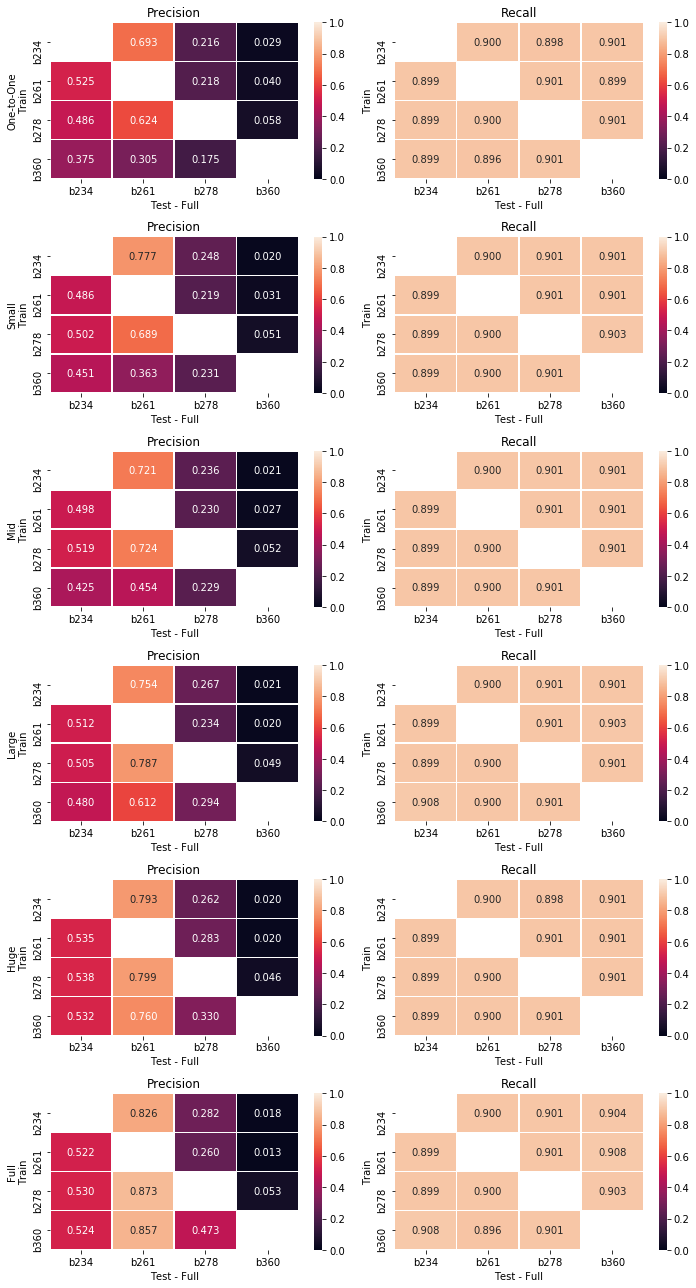

In [18]:
def as_df(data):
    rows, tiles = [], sorted(list(data.keys()))
    for rname in tiles:
        row = data[rname].copy()
        row.update({"Train": rname}) 
        rows.append(row)
    df = pd.DataFrame(rows)
    df = df.set_index("Train")[tiles]
    return df

def heatmap(ax, results, fp):
    cmap = sns.cm.rocket
    
    fix_recall, fix_precs = {}, {}
    for r in results:
        train_name, test_name = r["train_name"], r["test_name"]
        
        if train_name not in fix_recall:
            fix_recall[train_name] = {}
            fix_precs[train_name] = {}
            
        precs, recalls, probs = r.prec_rec_curve
        
        idx = nearest(recalls, fp)
        
        fix_recall[train_name][test_name] = recalls[idx]
        fix_precs[train_name][test_name] = precs[idx]
        
    fix_precs = as_df(fix_precs)
    fix_recall = as_df(fix_recall)
    
    sns.heatmap(fix_precs, annot=True, fmt='.3f',  linewidths=.5, ax=ax[0], cmap=cmap, center=.5, vmin=0., vmax=1.)
    ax[0].set_xlabel("Test - Full")
    ax[0].set_title(u"Precision".format(fp))
    
    sns.heatmap(fix_recall, annot=True, fmt='.3f', linewidths=.5, ax=ax[1], cmap=cmap, center=.5, vmin=0., vmax=1.)
    ax[1].set_xlabel("Test - Full")
    ax[1].set_title(u"Recall".format(fp))

fig, axes = plt.subplots(len(all_results), 2, figsize=(10, 3*len(all_results)))

for rname, axs in zip(all_results, axes):
    heatmap(axs, all_results[rname], 0.90)
    axs[0].set_ylabel(f"{rname}\n{axs[0].get_ylabel()}")
    
fig.tight_layout()
fig.savefig(plot_path / "heatmap.pdf")

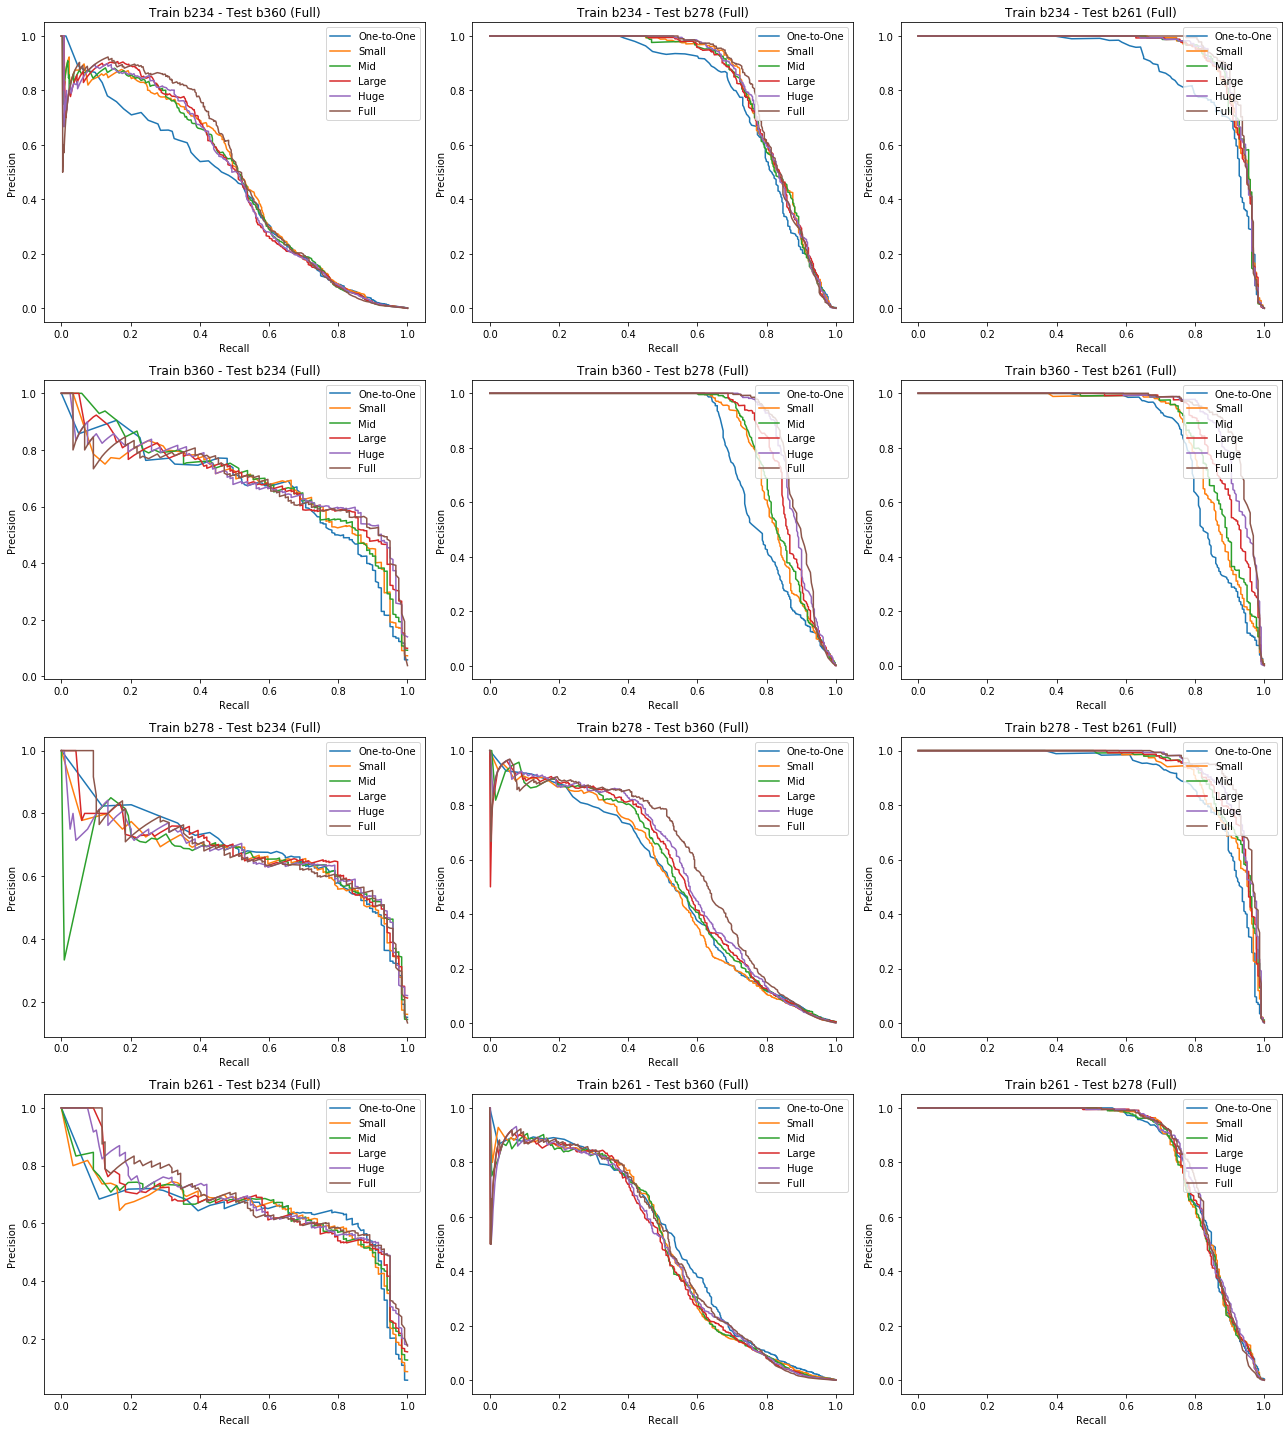

In [19]:
def plot_prec_roc_curve(ax, train_name, test_name, all_results):
    for rname, results in all_results.items():
        for r in results:
            if r.test_name == test_name and r.train_name == train_name:
                ax.plot(r.prec_rec_curve[1], r.prec_rec_curve[0], label=rname)
                break
    ax.set_title("Train {} - Test {} (Full)".format(train_name, test_name))
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.legend(loc='upper right')

fig, axes = plt.subplots(4, 3, figsize=(18, 20))
axes = it.chain(*axes)
for train_name in tiles:
    for test_name in tiles:
        if train_name == test_name:
            continue
        ax = next(axes)
        plot_prec_roc_curve(ax, train_name, test_name, all_results)
fig.tight_layout()
fig.savefig(plot_path  / "prec_rec_curve.pdf")